In [1]:
!git clone https://github.com/letsslipaway/btc_price_prediction.git
%cd btc_price_prediction

Cloning into 'btc_price_prediction'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 46 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 288.90 KiB | 1.33 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/btc_price_prediction


In [2]:
pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 28.5 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a3b566218be8dabc9d0f8040525875f41c5bcc37dbe34dfee2926f7bebeb2423
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


# **Libraries import**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import yfinance as yf
import ta
from pandas_datareader import data as pdr
import requests
import warnings
warnings.filterwarnings("ignore")

# **Project Goal**

Our project aims to predict Bitcoin’s price movement within a specific time horizon, identifying whether it will rise by a certain percentage (e.g., +5%) with a probability above 50%. The overarching objective is to design a model that can provide potentially stable profits by minimizing false signals.

**Core data**

We based our analysis on historical BTC-USD price data sourced from Yahoo Finance. This dataset provided the foundational OHLCV (Open, High, Low, Close, Volume) data for Bitcoin, which we used to derive various technical and macroeconomic features.

In [ ]:
#loading dataset for specific ticker from yfinance
def load_data(ticker='BTC-USD', period='max'):
    df = yf.download(ticker, period=period)
    df = df.droplevel(level=1, axis=1)
    df.dropna(inplace=True)
    return df

# **Features and Indicators**

**Proportional Technical Indicators**

We focus on proportional (normalized) indicators so that the model’s predictions remain robust regardless of Bitcoin’s absolute price.
These indicators come from classic technical analysis literature (e.g., John J. Murphy’s Technical Analysis of the Financial Markets) and are well-documented in libraries like ta for Python.

**Additional On-Chain Indicators (Crypto-Specific)**

In principle, there exist advanced on-chain metrics such as Active Addresses compared to total addresses, transaction volumes, realized cap, MVRV, etc. However, many of these data sources require paid subscriptions (e.g., Glassnode, CryptoQuant). While they can significantly enhance predictive power, their cost often prohibits use in smaller, proof-of-concept projects. Still, the fact these indicators are behind paywalls suggests they can boost model profitability if utilized in real-world trading scenarios.

In [ ]:
def add_proportional_indicators(
    df,
    rsi_window=14,
    stoch_window=14,
    stoch_smooth=3,
    wpr_lbp=14,
    bb_window=20,
    bb_std=2,
    macd_fast=12,
    macd_slow=26,
    macd_sign=9,
    adx_window=14,
    mfi_window=14,
    cci_window=20,
    atr_window=14,
    ):

    # 1. RSI, Stoch, Williams %R, Bollinger %B, MACD(proportional)
    df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=rsi_window).rsi()

    stoch = ta.momentum.StochasticOscillator(
        high=df['High'], low=df['Low'], close=df['Close'],
        window=stoch_window, smooth_window=stoch_smooth
    )
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    df['williams_r'] = ta.momentum.WilliamsRIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], lbp=wpr_lbp
    ).williams_r()

    bb = ta.volatility.BollingerBands(
        close=df['Close'], window=bb_window, window_dev=bb_std
    )
    df['bb_b'] = bb.bollinger_pband()

    macd_obj = ta.trend.MACD(
        close=df['Close'], window_slow=macd_slow, window_fast=macd_fast, window_sign=macd_sign
    )
    df['macd_diff'] = macd_obj.macd_diff()
    df['macd_prop'] = df['macd_diff'] / df['Close'] * 100
    df.drop(columns=['macd_diff'], inplace=True)

    # 2. ADX (0..100)
    adx = ta.trend.ADXIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], window=adx_window
    )
    df['adx'] = adx.adx()
    df['di_plus'] = adx.adx_pos()
    df['di_minus'] = adx.adx_neg()

    # 3. MFI (0..100)
    mfi = ta.volume.MFIIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=mfi_window
    )
    df['mfi'] = mfi.money_flow_index()

    # 4. CCI (±200+)
    cci = ta.trend.CCIIndicator(
        high=df['High'], low=df['Low'], close=df['Close'], window=cci_window
    )
    df['cci'] = cci.cci()

    # 5. ATR (relative)
    atr = ta.volatility.AverageTrueRange(
        high=df['High'], low=df['Low'], close=df['Close'], window=atr_window
    )
    df['atr'] = atr.average_true_range()
    df['atr_rel'] = df['atr'] / df['Close'] * 100
    df.drop(columns=['atr'], inplace=True)

    df.dropna(inplace=True)

    return df

**Additional Non-Technical Features**


*   **Fear & Greed Index:** Reflects the market’s emotional state (greed versus fear).

*Limitation: Data is only available from 2018 onward, reducing the historical sample size.*
*   **Dollar Index (DXY):** A measure of the U.S. dollar strength relative to a basket of other currencies.

*Stronger dollar movements may correlate with Bitcoin price behavior.*


**Macro Indicators**



*   **Consumer Price Index (CPI)**: reflects inflation levels.
*   **Federal Funds Rate:** shows central bank policy stance.


Empirically, these features can further stabilize and improve performance, as macroeconomic conditions often affect risk-on/off sentiment in crypto markets.

In [ ]:
def load_fear_greed_index(limit=10000, date_format='world'):
    url = "https://api.alternative.me/fng/"
    params = {
        'limit': limit,
        'format': 'json',
        'date_format': date_format
    }

    response = requests.get(url, params=params)
    data = response.json()

    records = data.get('data', [])

    df_fg = pd.DataFrame(records)

    df_fg['timestamp'] = pd.to_datetime(df_fg['timestamp'], format='%d-%m-%Y')
    df_fg.set_index('timestamp', inplace=True)
    df_fg.drop(columns=['time_until_update', 'value_classification'], inplace=True)
    df_fg.rename(columns={'value': 'fear_greed'}, inplace=True)
    df_fg['fear_greed'] = df_fg['fear_greed'].astype(float)

    return df_fg

def add_fear_greed_index(df, df_fg):
    df = df.copy()
    df = df.join(df_fg, how='inner')
    return df

def add_dollar_index_feature(df):
    start_date = df.index.min().strftime('%Y-%m-%d')
    end_date = df.index.max().strftime('%Y-%m-%d')

    dxy_data = yf.download('DX-Y.NYB', start=start_date, end=end_date)
    dxy_data = dxy_data.droplevel(level=1, axis=1)
    dxy = dxy_data[['Close']]

    dxy.rename(columns={'Close': 'dollar_index'}, inplace=True)
    df = df.join(dxy, how='inner')

    return df

def add_macro_indicators(df_prices):
    start_date = df_prices.index.min()
    end_date = df_prices.index.max()

    df_prices = df_prices.copy()
    if not isinstance(df_prices.index, pd.DatetimeIndex):
        df_prices.index = pd.to_datetime(df_prices.index)
    macro_series = {
        'CPI':       'CPIAUCSL',  # Consumer Price Index
        'FedFunds':  'FEDFUNDS',  # Effective Federal Funds Rate
    }
    df_macro = pd.DataFrame()
    for col_name, fred_code in macro_series.items():
        try:
            temp = pdr.DataReader(fred_code, 'fred', start_date, end_date)
            temp.rename(columns={fred_code: col_name}, inplace=True)
            if df_macro.empty:
                df_macro = temp
            else:
                df_macro = df_macro.join(temp, how='outer')
        except Exception as e:
            print(f"Error when loading {fred_code}: {e}")

    all_days = pd.date_range(start=df_prices.index.min(), end=df_prices.index.max(), freq='D')
    df_macro_daily = df_macro.reindex(all_days).ffill()

    df_merged = df_prices.join(df_macro_daily, how='left')

    df_merged.ffill(inplace=True)
    df_merged.dropna(inplace=True)

    return df_merged

**Sliding Window (Lag Features) and PCA**


*   **Sliding Window:** Considering the influence of the previous N days’ data on the target price. For instance, using 5, 10, or 15 days of historical indicators or prices.
*   **PCA (Principal Component Analysis):** Potentially applies after forming a large feature set (especially from multiple lag days) to reduce dimensionality.

In [ ]:
features=['rsi','stoch_k','stoch_d','williams_r', 'bb_b', 'macd_prop']

def add_sliding_window_in_df(df, features=features, window_size=5):
    df = df.copy()
    for f in features:
        for i in range(1, window_size + 1):
            df[f'{f}_lag_{i}'] = df[f].shift(i)
    df.dropna(inplace=True)

    return df

def add_pca(X_train, X_valid, X_test, n_components=3, visualize=True):
    #normalization before implementing pca
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_valid_pca = pca.transform(X_valid_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    pca_col_names = [f'pca_{i+1}' for i in range(n_components)]
    X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_col_names, index=X_train.index)
    X_valid_pca_df = pd.DataFrame(X_valid_pca, columns=pca_col_names, index=X_valid.index)
    X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_col_names, index=X_test.index)

    #this way we can se how much variance we omit
    if visualize:
        plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),
        np.cumsum(pca.explained_variance_ratio_), marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance')
        plt.show()

    return X_train_pca_df, X_valid_pca_df, X_test_pca_df


#**Target Definition**

We considered two methods to label the data:

**Take Profit Only:** If Bitcoin’s price rises by +X% within N-days, label = 1. Otherwise, 0.

*This approach can yield a more balanced dataset since downward movements are not strictly penalized.*

**Take Profit & Stop Loss:** The price must reach +X% without first dipping below −Y% within N-days

*This typically creates a more unbalanced dataset, because any significant drop triggers a stop and results in more negative labels.
However, it promises a more stable trading strategy if successfully captured.*

In [ ]:
def target_takeprofit(df, horizon=5, tp=0.03):
    df = df.copy()
    df['future_high'] = (
        df['High']
          .shift(-1)
          .rolling(window=horizon)
          .max()
          .shift(-(horizon-1))
    )

    df['target'] = (df['future_high'] > df['Close'] * (1 + tp)).astype(int)

    df = df.iloc[:-horizon]
    df.drop(columns=['future_high', 'Close','Open','High','Low','Volume'], inplace=True)

    return df

def target_takeprofit_stoploss(df, horizon=5, tp=0.03, sl=0.02):
    df = df.copy()
    df['target'] = np.nan

    prices = df['Close'].values
    highs = df['High'].values
    lows = df['Low'].values

    n = len(df)

    for i in range(n - horizon):
        start_price = prices[i]
        tp_level = start_price * (1 + tp)
        sl_level = start_price * (1 - sl)

        window_highs = highs[i+1 : i + horizon + 1]
        window_lows  = lows [i+1 : i + horizon + 1]

        idx_tp_candidates = np.where(window_highs >= tp_level)[0]
        day_tp = idx_tp_candidates[0] if len(idx_tp_candidates) > 0 else None

        idx_sl_candidates = np.where(window_lows <= sl_level)[0]
        day_sl = idx_sl_candidates[0] if len(idx_sl_candidates) > 0 else None

        if (day_tp is None) and (day_sl is None):
            df.loc[df.index[i], 'target'] = 0
        elif (day_tp is not None) and (day_sl is None):
            df.loc[df.index[i], 'target'] = 1
        elif (day_tp is None) and (day_sl is not None):
            df.loc[df.index[i], 'target'] = 0
        else:
            if day_tp < day_sl:
                df.loc[df.index[i], 'target'] = 1
            else:
                df.loc[df.index[i], 'target'] = 0

    df.dropna(subset=['target'], inplace=True)
    df.drop(columns=['Close','Open','High','Low','Volume'], inplace=True)

    return df


# **Data Splitting**
Given these are time series, we use a time-aware split

**Training (Train):** Used for both initial model building and cross-validation.

**Validation (Valid):** An intermediary set for checking out-of-sample performance and adjusting thresholds.

**Test:** A final “hold-out” set, never touched until the end, to measure true generalization.

In [ ]:
def train_valid_test_split(X, y, train_size=0.6, valid_size=0.15):
    n = len(X)
    train_end = int(n * train_size)
    valid_end = int(n * (train_size + valid_size))

    X_train, y_train = X[:train_end], y[:train_end]
    X_valid, y_valid = X[train_end:valid_end], y[train_end:valid_end]
    X_test,  y_test  = X[valid_end:], y[valid_end:]

    return X_train, y_train, X_valid, y_valid, X_test, y_test


# **Workflow Overview**
**Feature Engineering:**

First, we load the dataset and add the core proportional technical indicators. Preliminary tests on out-of-the-box models show that incorporating the Dollar Index and macroeconomic indicators slightly improves the results. Although utilizing the Fear/Greed Index reduces the amount of available historical data, it still enhances overall performance.

**Experimenting with Horizon & Stop-Loss:**

We tested different horizons (e.g., 10 days) and thresholds (+5% TP, −4% SL). These gave us a somewhat balanced approach, ensuring balances dataset and potentially profitable strategy

In [ ]:
df = load_data(ticker='BTC-USD', period='max')
df = add_proportional_indicators(df)
df = add_fear_greed_index(df, load_fear_greed_index())
df = add_dollar_index_feature(df)
df = add_macro_indicators(df)
#df = add_sliding_window_in_df(df, window_size=10)
df = target_takeprofit_stoploss(df, horizon=10, tp=0.05, sl=0.04)

#let's check how much is dataset imbalanced
df[df['target']==1].shape[0] / df.shape[0]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


0.44794050343249425

In [ ]:
X = df.drop(columns=['target'])
y = df['target']
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)
#X_train, X_valid, X_test = add_pca(X_train, X_valid, X_test, n_components=6, visualize=True)

In [ ]:
X_train.head()

,rsi,stoch_k,stoch_d,williams_r,bb_b,macd_prop,adx,di_plus,di_minus,mfi,cci,atr_rel,fear_greed,dollar_index,CPI,FedFunds
2018-02-01,32.505630,8.349643,13.571569,-91.650357,0.011343,-1.409894,34.516014,12.212113,36.858379,45.704092,-164.543264,13.575540,30.0,88.669998,249.529,1.42
2018-02-02,31.214760,19.490396,13.727154,-80.509604,-0.014839,-2.009340,36.041343,11.256443,39.759198,37.586719,-214.826245,14.202324,15.0,89.199997,249.529,1.42
2018-02-05,26.176396,3.758595,14.037466,-96.241405,-0.150800,-4.113611,39.626481,10.233754,39.503738,36.634245,-202.110680,18.376223,11.0,89.550003,249.529,1.42
2018-02-06,32.424583,28.466770,14.516066,-71.533230,0.061484,-3.396009,41.231588,9.232245,39.484133,36.727907,-167.964244,16.966310,8.0,89.589996,249.529,1.42
2018-02-07,31.940899,26.252162,19.492509,-73.747838,0.096551,-3.056190,41.874070,12.176220,36.750131,34.668268,-117.632592,17.221191,36.0,90.260002,249.529,1.42


# **Initial Model Comparison:**

We train three “out-of-the-box” models: Logistic Regression, Random Forest, and XGBoost on the training set, evaluate on the validation set.

All show comparable Precision/Recall trade-offs, but we emphasize Precision to minimize false positives (“false trades”).

Observing their Precision-Recall curves, XGBoost yields more consistent performance, unaffected by which indicators we choose.

In [ ]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid, pca='False', window=0):
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    precision = precision_score(y_valid, y_pred_valid)
    recall = recall_score(y_valid, y_pred_valid)

    return {
        'model_name': model.__class__.__name__,
        'pca': pca,
        'window': window,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'valid_accuracy': accuracy_score(y_valid, y_pred_valid),
        'valid_precision': precision,
        'valid_recall': recall,
    }


In [ ]:
def linear_model(X_train, y_train, X_valid, y_valid):
    #linear model
    lr = LogisticRegression(class_weight='balanced', max_iter=10000)
    lr.fit(X_train, y_train)
    val_pred_lr = lr.predict_proba(X_valid)[:, 1]

    return lr, val_pred_lr

def forest_model(X_train, y_train, X_valid, y_valid):
    #random forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)
    val_pred_rf = rf.predict_proba(X_valid)[:, 1]

    return rf, val_pred_rf

def xgb_model(X_train, y_train, X_valid, y_valid):
    #xgboost
    xgb = XGBClassifier(n_estimators=100, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    val_pred_xgb = xgb.predict_proba(X_valid)[:, 1]

    return xgb, val_pred_xgb


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

lr, val_pred_lr = linear_model(X_train_scaled, y_train, X_valid_scaled, y_valid)
rf, val_pred_rf = forest_model(X_train, y_train, X_valid, y_valid)
xgb, val_pred_xgb = xgb_model(X_train, y_train, X_valid, y_valid)

**Observations on Overfitting**

Random Forest and XGBoost typically achieve near 100% accuracy on training data, showing obvious overfitting.
However, their validation performance remains comparable to Logistic Regression. We plan to address overfitting more thoroughly after these initial comparisons

In [ ]:
experiment_results = []

experiment_results.append(evaluate_model(lr, X_train_scaled, y_train, X_valid_scaled, y_valid))
experiment_results.append(evaluate_model(rf, X_train, y_train, X_valid, y_valid))
experiment_results.append(evaluate_model(xgb, X_train, y_train, X_valid, y_valid))

expirement_df = pd.DataFrame(experiment_results)
expirement_df

,model_name,pca,window,train_accuracy,valid_accuracy,valid_precision,valid_recall
0,LogisticRegression,False,0,0.592557,0.555133,0.400000,0.034783
1,RandomForestClassifier,False,0,1.000000,0.528517,0.448276,0.339130
2,XGBClassifier,False,0,1.000000,0.539924,0.472727,0.452174


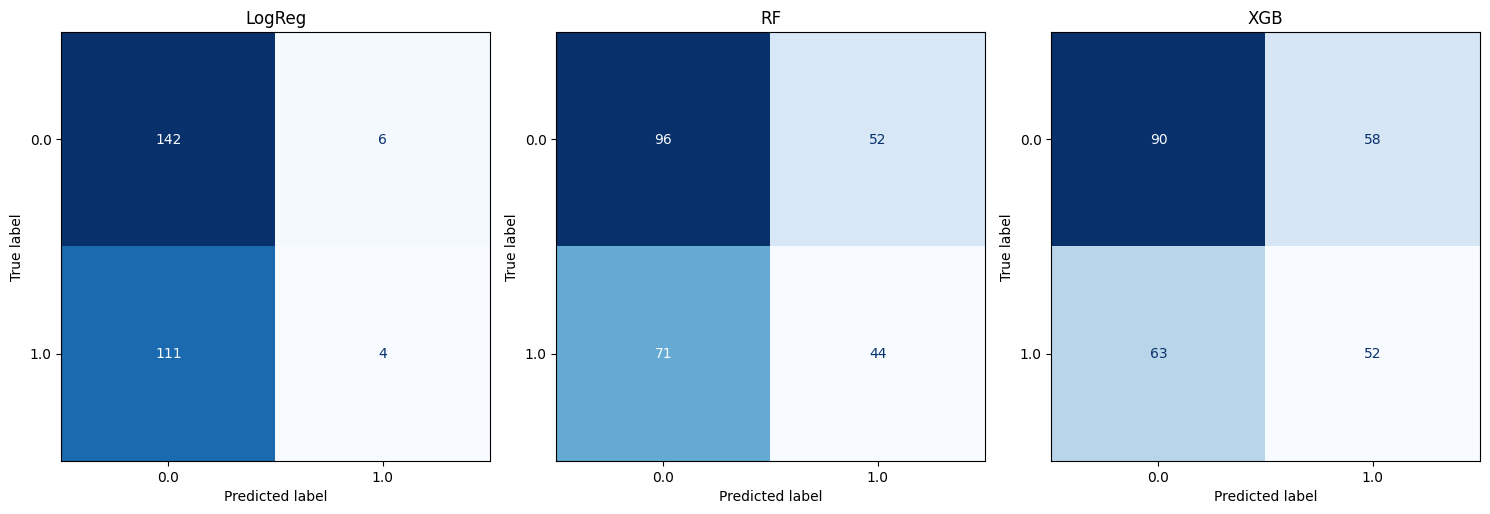

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(y_valid, (val_pred_lr >= 0.5).astype(int), ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title('LogReg')

ConfusionMatrixDisplay.from_predictions(y_valid, (val_pred_rf >= 0.5).astype(int), ax=axes[1],   cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title('RF')

ConfusionMatrixDisplay.from_predictions(y_valid, (val_pred_xgb >= 0.5).astype(int), ax=axes[2], cmap=plt.cm.Blues, colorbar=False)
axes[2].set_title('XGB')

plt.tight_layout()
plt.show()


# **Deciding on XGBoost:**

XGB looks like the most prospective option due to stability and its consistent performance across multiple feature sets. (as clearly seen on precision-recall charts)

It's worth mentioning that feature importances reveal that XGB and RF share similar top features, while Logistic Regression differs markedly.

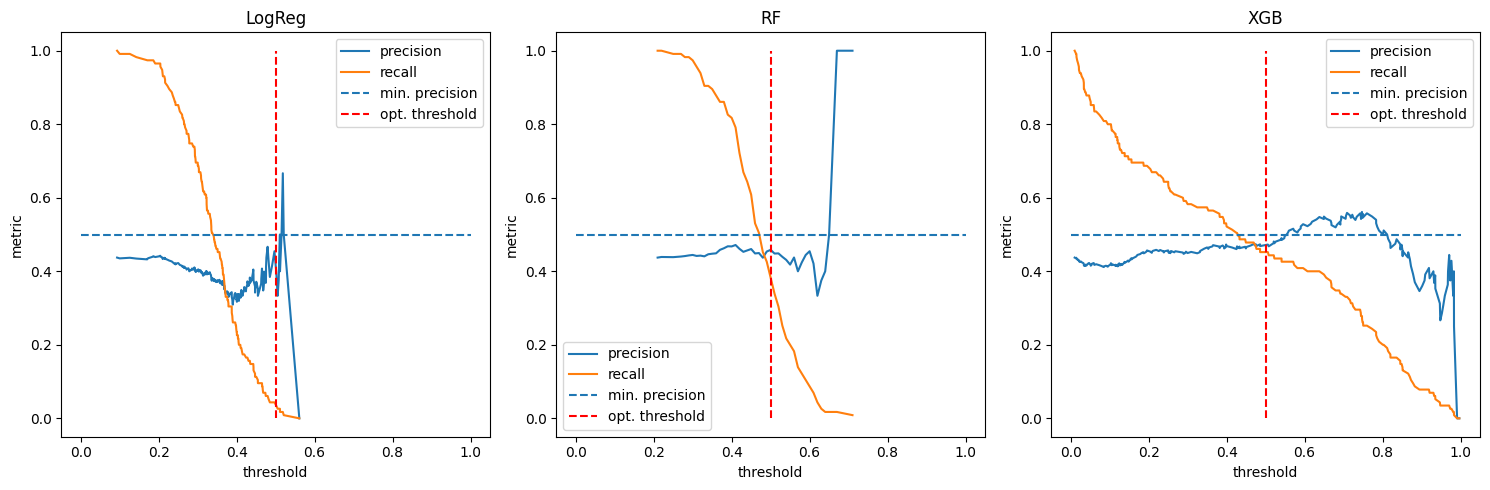

In [ ]:
precision1, recall1, thresholds1 = precision_recall_curve(y_valid, val_pred_lr)
precision2, recall2, thresholds2 = precision_recall_curve(y_valid, val_pred_rf)
precision3, recall3, thresholds3 = precision_recall_curve(y_valid, val_pred_xgb)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

tau = 0.5

axes[0].plot(thresholds1, precision1[:-1], label='precision')
axes[0].plot(thresholds1, recall1[:-1], label='recall')
axes[0].hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
axes[0].vlines(tau, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')

axes[0].legend()
axes[0].set_xlabel('threshold')
axes[0].set_ylabel('metric')
axes[0].set_title('LogReg')

axes[1].plot(thresholds2, precision2[:-1], label='precision')
axes[1].plot(thresholds2, recall2[:-1], label='recall')
axes[1].hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
axes[1].vlines(tau, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')

axes[1].legend()
axes[1].set_xlabel('threshold')
axes[1].set_ylabel('metric')
axes[1].set_title('RF')


axes[2].plot(thresholds3, precision3[:-1], label='precision')
axes[2].plot(thresholds3, recall3[:-1], label='recall')
axes[2].hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
axes[2].vlines(tau, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')

axes[2].legend()
axes[2].set_xlabel('threshold')
axes[2].set_ylabel('metric')
axes[2].set_title('XGB')

plt.tight_layout()
plt.show()


In [ ]:
importances = lr.coef_[0]
feature_importances = pd.Series(importances, index=X_train.columns)

feature_importances.sort_values(ascending=False, key=abs, inplace=True)
print(feature_importances.head(10))


bb_b          0.557987
di_minus     -0.273685
mfi           0.217257
macd_prop    -0.210247
adx           0.201125
FedFunds     -0.181398
fear_greed   -0.171707
stoch_d      -0.144805
rsi          -0.138405
CPI          -0.082112
dtype: float64


In [ ]:
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
print(feature_importances[:10].sort_values(ascending=False))

adx           0.089414
di_minus      0.077141
macd_prop     0.064168
mfi           0.062584
stoch_d       0.060404
rsi           0.060304
di_plus       0.059883
bb_b          0.055863
stoch_k       0.053230
williams_r    0.052456
dtype: float64


In [ ]:
importances = xgb.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
print(feature_importances[:10].sort_values(ascending=False))

adx           0.085269
stoch_k       0.071079
di_minus      0.068144
rsi           0.061624
stoch_d       0.059022
macd_prop     0.057061
bb_b          0.056733
mfi           0.056035
di_plus       0.052710
williams_r    0.000000
dtype: float32


# **Sliding Window & PCA**

Testing windows of varioius sizes and incorporation of PCA does not significantly improve metrics.
Consequently, we opt not to complicate the pipeline further. The model uses core indicators (technical + macro + Fear & Greed) in their proportional forms.

In [ ]:
#windows(5, 10, 15)
for w in [5, 10, 15]:
    df_window = add_sliding_window_in_df(df, window_size=w)
    X = df_window.drop(columns=['target'])
    y = df_window['target']
    X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)
    xgb, val_pred_xgb = xgb_model(X_train, y_train, X_valid, y_valid)

    experiment_results.append(evaluate_model(xgb, X_train, y_train, X_valid, y_valid, pca='False', window=w))

In [ ]:
expirement_df = pd.DataFrame(experiment_results)
expirement_df

,model_name,pca,window,train_accuracy,valid_accuracy,valid_precision,valid_recall
0,LogisticRegression,False,0,0.592557,0.555133,0.400000,0.034783
1,RandomForestClassifier,False,0,1.000000,0.528517,0.448276,0.339130
2,XGBClassifier,False,0,1.000000,0.539924,0.472727,0.452174
3,XGBClassifier,False,5,1.000000,0.580153,0.520325,0.556522
4,XGBClassifier,False,10,1.000000,0.555556,0.500000,0.413793
5,XGBClassifier,False,15,1.000000,0.538462,0.481928,0.341880


In [ ]:
#windows with pca
for w in [5, 10, 15, 20, 25]:
    for c in [6, 10, 15, 20, 25, 30]:
        df_window = add_sliding_window_in_df(df, window_size=w)
        X = df_window.drop(columns=['target'])
        y = df_window['target']
        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)
        X_train, X_valid, X_test = add_pca(X_train, X_valid, X_test, n_components=c, visualize=False)

        xgb, val_pred_xgb = xgb_model(X_train, y_train, X_valid, y_valid)

        experiment_results.append(evaluate_model(xgb, X_train, y_train, X_valid, y_valid, pca=c, window=w))

In [ ]:
expirement_df = pd.DataFrame(experiment_results)
expirement_df.head(100)

,model_name,pca,window,train_accuracy,valid_accuracy,valid_precision,valid_recall
0,LogisticRegression,False,0,0.592557,0.555133,0.400000,0.034783
1,RandomForestClassifier,False,0,1.000000,0.528517,0.448276,0.339130
2,XGBClassifier,False,0,1.000000,0.539924,0.472727,0.452174
3,XGBClassifier,False,5,1.000000,0.580153,0.520325,0.556522
4,XGBClassifier,False,10,1.000000,0.555556,0.500000,0.413793
5,XGBClassifier,False,15,1.000000,0.538462,0.481928,0.341880
6,XGBClassifier,6,5,1.000000,0.465649,0.431694,0.686957
7,XGBClassifier,10,5,1.000000,0.427481,0.412935,0.721739
8,XGBClassifier,15,5,1.000000,0.431298,0.383562,0.486957
9,XGBClassifier,20,5,1.000000,0.500000,0.435484,0.469565


# **Cross-Validation & Hyperparameter Tuning:**

Using time-aware cross-validation (TimeSeriesSplit) on the training set, we optimized XGBoost’s hyperparameters. Precision was our primary optimization goal due to the critical need to minimize false signals, while maintaining recall above an acceptable threshold. Our cross-validation results showed that XGBoost maintained a stable precision above 50% across various hyperparameter configurations, even as recall gradually declined.

In [ ]:
def timeaware_cv_xgb(X, y, n_splits=5):
    xgb_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
    )

    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 300, 500],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='precision',
        cv=tscv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    print("Best xgb params:", grid_search.best_params_)
    print("Best CV Precision score:", grid_search.best_score_)

    return grid_search.best_estimator_, grid_search.best_params_


In [ ]:
df.head(5)

,rsi,stoch_k,stoch_d,williams_r,bb_b,macd_prop,adx,di_plus,di_minus,mfi,cci,atr_rel,fear_greed,dollar_index,CPI,FedFunds,target
2018-02-01,32.505630,8.349643,13.571569,-91.650357,0.011343,-1.409894,34.516014,12.212113,36.858379,45.704092,-164.543264,13.575540,30.0,88.669998,249.529,1.42,0.0
2018-02-02,31.214760,19.490396,13.727154,-80.509604,-0.014839,-2.009340,36.041343,11.256443,39.759198,37.586719,-214.826245,14.202324,15.0,89.199997,249.529,1.42,0.0
2018-02-05,26.176396,3.758595,14.037466,-96.241405,-0.150800,-4.113611,39.626481,10.233754,39.503738,36.634245,-202.110680,18.376223,11.0,89.550003,249.529,1.42,0.0
2018-02-06,32.424583,28.466770,14.516066,-71.533230,0.061484,-3.396009,41.231588,9.232245,39.484133,36.727907,-167.964244,16.966310,8.0,89.589996,249.529,1.42,0.0
2018-02-07,31.940899,26.252162,19.492509,-73.747838,0.096551,-3.056190,41.874070,12.176220,36.750131,34.668268,-117.632592,17.221191,36.0,90.260002,249.529,1.42,1.0


In [ ]:
X = df.drop(columns=['target'])
y = df['target']
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)
xgb_estimator, xgb_params = timeaware_cv_xgb(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best xgb params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best CV Precision score: 0.547703764370431


In [ ]:
experiment_results.append(evaluate_model(xgb_estimator, X_train, y_train, X_valid, y_valid))

expirement_df = pd.DataFrame(experiment_results)
expirement_df

,model_name,pca,window,train_accuracy,valid_accuracy,valid_precision,valid_recall
0,LogisticRegression,False,0,0.592557,0.555133,0.400000,0.034783
1,RandomForestClassifier,False,0,1.000000,0.528517,0.448276,0.339130
2,XGBClassifier,False,0,1.000000,0.539924,0.472727,0.452174
3,XGBClassifier,False,5,1.000000,0.580153,0.520325,0.556522
4,XGBClassifier,False,10,1.000000,0.555556,0.500000,0.413793
5,XGBClassifier,False,15,1.000000,0.538462,0.481928,0.341880
6,XGBClassifier,6,5,1.000000,0.465649,0.431694,0.686957
7,XGBClassifier,10,5,1.000000,0.427481,0.412935,0.721739
8,XGBClassifier,15,5,1.000000,0.431298,0.383562,0.486957
9,XGBClassifier,20,5,1.000000,0.500000,0.435484,0.469565


# **Threshold Optimization:**

Observing that the distribution of probability estimates for positive class predictions is generally normal—meaning the model was rarely highly confident—we experimented with lowering the classification threshold. By leaving the threshold at 0.5 on the validation set, we successfully increased recall to around 40% while keeping precision above 50%.

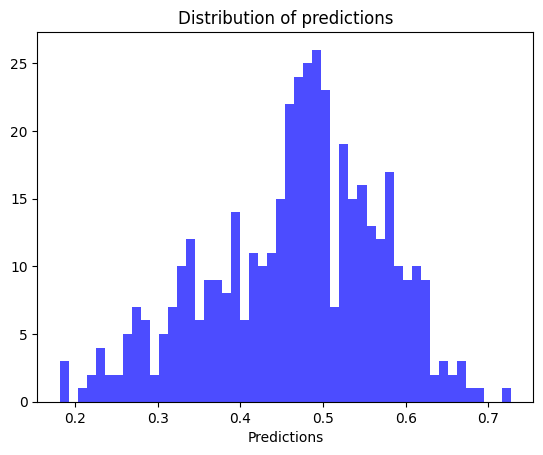

In [ ]:
plt.hist(xgb_estimator.predict_proba(X_test)[:, 1], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of predictions')
plt.xlabel('Predictions')
plt.show()


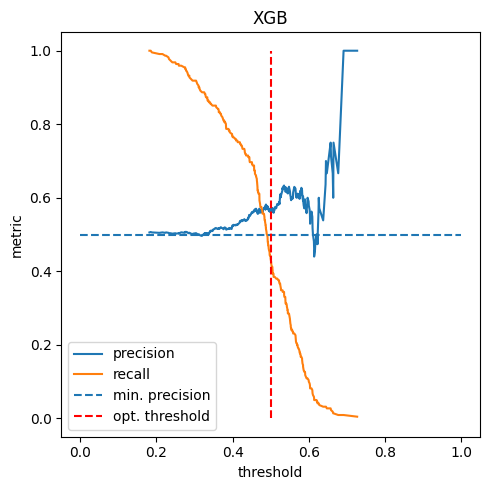

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_estimator.predict_proba(X_test)[:, 1])

fig, axes = plt.subplots(figsize=(5, 5))

tau = 0.5
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.hlines(y=0.5, xmin=0, xmax=1, label='min. precision', linestyles='dashed')
plt.vlines(tau, ymin=0, ymax=1, color='red', label='opt. threshold', linestyles='dashed')

plt.legend()
plt.xlabel('threshold')
plt.ylabel('metric')
plt.title('XGB')

plt.tight_layout()
plt.show()


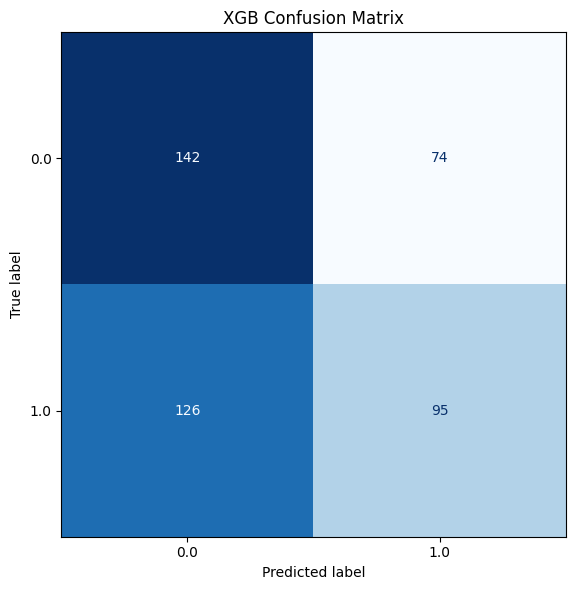

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

y_pred = (xgb_estimator.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    cmap=plt.cm.Blues,
    colorbar=False
)
ax.set_title('XGB Confusion Matrix')

plt.tight_layout()
plt.show()


# **Final Evaluation on Test Set:**

With the threshold set to 0.5, we applied our optimized XGBoost model to the untouched test set. The model achieved a precision of 56% and a recall of 42%, which confirmed its stable performance and suitability for practical applications.

A fixed random state was intentionally omitted to demonstrate that the approach ensures model stability. As a result, running the code from the beginning may show slightly different results.

In [ ]:
probas = xgb_estimator.predict_proba(X_test)[:, 1]

tau = 0.5
y_pred = (probas >= tau).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.5621301775147929
Recall: 0.4298642533936652


# **Conclusion:**
The combination of robust proportional technical and macroeconomic indicators, careful time-aware cross-validation, and strategic threshold adjustment has resulted in an XGBoost model capable of providing reliable predictions for Bitcoin price movements. The final model's precision and recall metrics suggest that, despite inherent uncertainties in financial data, our approach can yield a stable and potentially profitable trading signal with a reduced likelihood of false positives.